In [87]:
from utils.load import make_total_df,get_feature_names, get_indv_df

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
df = make_total_df()
df = df.drop("Y_labels", axis=1)

In [88]:
df.head()

,FBCosDist_BusinessIndustry.,FBCosDist_Education.,FBCosDist_FamilyRelationships.,FBCosDist_FitnessWellness.,FBCosDist_FoodDrink.,FBCosDist_HobbiesActivities.,FBCosDist_LifestyleCulture.,FBCosDist_NewsEntertainment.,FBCosDist_NonLocalBus.,FBCosDist_People.,...,FBManDist_HobbiesActivities.,FBManDist_LifestyleCulture.,FBManDist_NewsEntertainment.,FBManDist_NonLocalBus.,FBManDist_People.,FBManDist_ShoppingFashion.,FBManDist_SportsOutdoors.,FBManDist_Technology.,FBManDist_TravelPlacesEvents.,FBManDist_Uncategorized.
c_to_c,,,,,,,,,,,,,,,,,,,,,
AG_AE,0.261507,0.190169,0.045053,0.104336,0.253270,0.211779,0.117196,0.074938,0.223101,0.711156,...,22.195177,14.782017,54.270207,242.646467,32.375634,10.206340,12.926806,8.118248,34.422627,17.015340
AL_AE,0.236488,0.073067,0.073446,0.089928,0.119030,0.175246,0.194526,0.069180,0.202676,0.713172,...,17.600375,12.415483,29.101487,172.894663,17.330872,5.620284,9.527579,5.938691,32.890397,10.196431
AL_AG,0.237967,0.216138,0.090740,0.111809,0.224615,0.223379,0.187709,0.101999,0.229894,0.717840,...,26.157027,15.266687,57.484249,259.423768,32.483852,10.078030,15.072849,9.026726,38.381617,16.959543
AM_AE,0.299419,0.099453,0.111057,0.100574,0.165536,0.196102,0.148088,0.030531,0.189267,0.665114,...,14.596972,10.208594,21.222717,139.262034,12.294202,6.258551,5.158487,6.190173,23.436977,8.983505
AM_AG,0.300475,0.255487,0.151110,0.078193,0.232395,0.181091,0.156594,0.076052,0.212817,0.652625,...,22.094976,13.962780,55.035863,234.387755,29.894039,9.972139,13.802836,7.667930,27.837048,16.375097


In [89]:
df.shape

(16836, 60)

In [95]:
distance = pd.read_csv("data/distance_data/processed_distances.csv")
df_filled = distance.fillna(0)
df_arr = df_filled.to_numpy().reshape(-1, 1)
df_arr

array([[11712.02  ],
       [ 3702.809 ],
       [ 8082.156 ],
       ...,
       [    0.    ],
       [ 2186.206 ],
       [  396.8041]])

In [96]:
distance = pd.read_csv("data/distance_data/processed_distances.csv")
feature_names = get_feature_names('cos') + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
x = df.loc[:, feature_names].values 
x = np.concatenate((x, df_arr), axis=1)

x = StandardScaler().fit_transform(x) # normalizing the features
mean_vec = np.mean( x, axis=0)
cov_mat = np.cov( x.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

res = [n for n,i in enumerate(cum_var_exp) if i>90 ][0]  # Amount of vectors needed to explain 90 percent of the variance
pca = PCA(n_components=7)
pca.fit(x)
X = pca.transform(x)

print(X.shape)



(16836, 7)


In [15]:
Y = df["Y_labels"]
Y = np.log10(Y)

cos


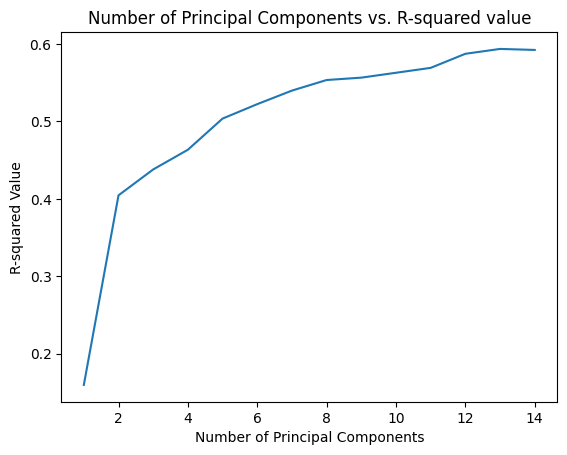

euc


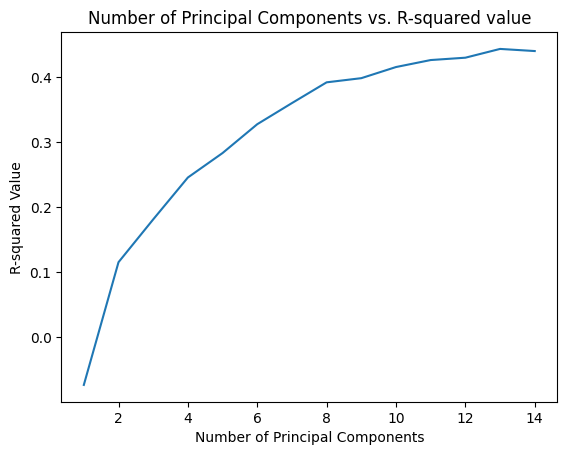

man


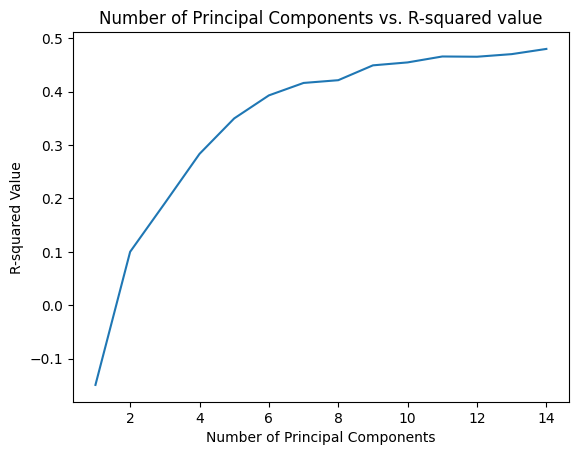

het


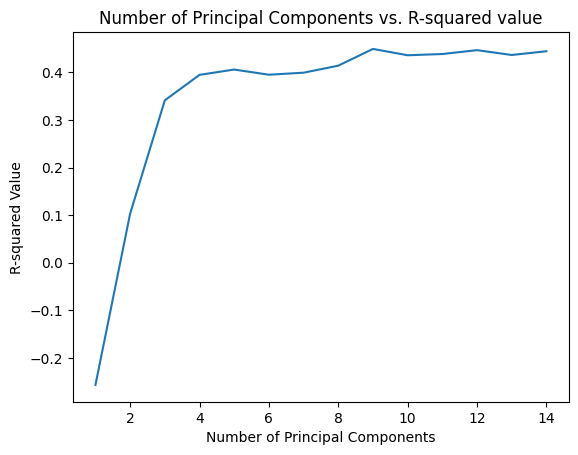

In [108]:
pcas = []
r2_scores = []

metrics = ['cos','euc','man','het']

for met in range(4):
    print(metrics[met])
    pcas = []
    r2_scores = []

    for i in range(1,15):
        feature_names = get_feature_names(metrics[met])# + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
        x = df.loc[:, feature_names].values 
    # x = np.concatenate((x, df_arr), axis=1)
        pca = PCA(n_components=i)
        pca.fit(x)
        X = pca.transform(x)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
        rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)
        prediction = rf.predict(X_test)
        r2 = r2_score(y_test, prediction)
        pcas.append(i)
        r2_scores.append(r2)

    plt.plot(pcas, r2_scores)

    # Add axis labels and a title to the plot
    plt.xlabel('Number of Principal Components')
    plt.ylabel('R-squared Value')
    plt.title('Number of Principal Components vs. R-squared value')

  #  plt.axvline(10, color='r', linestyle='--')

    # Show the plot
    plt.show()


In [100]:
print(pcas)
print(r2_scores)

for i,j in zip(pcas[10:],r2_scores[10:]):

    if j == max(r2_scores):
        print(i,j)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0.1679333968706428, 0.33834864890870286, 0.436175493402142, 0.5170012402584618, 0.5460098924060841, 0.5671036651898345, 0.5765554611477635, 0.5980744172113173, 0.6153683181230528, 0.6228843063670879, 0.6210198452410628, 0.625086668318257, 0.6237078624585544, 0.6281880500416038, 0.6257537048997529, 0.642310658837757, 0.642276255034741, 0.6400734175397683, 0.6375017918869663]
16 0.642310658837757


In [32]:
import matplotlib.pyplot as plt

In [111]:
pcas = []
r2_scores = []
for i in range(1,20):
    feature_names = get_feature_names(metrics[met]) + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
    x = df.loc[:, feature_names].values 
# x = np.concatenate((x, df_arr), axis=1)
    pca = PCA(n_components=i)
    pca.fit(x)
    X = pca.transform(x)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)
    prediction = rf.predict(X_test)
    r2 = r2_score(y_test, prediction)
    pcas.append(i)
    r2_scores.append(r2)

In [113]:
pcas

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

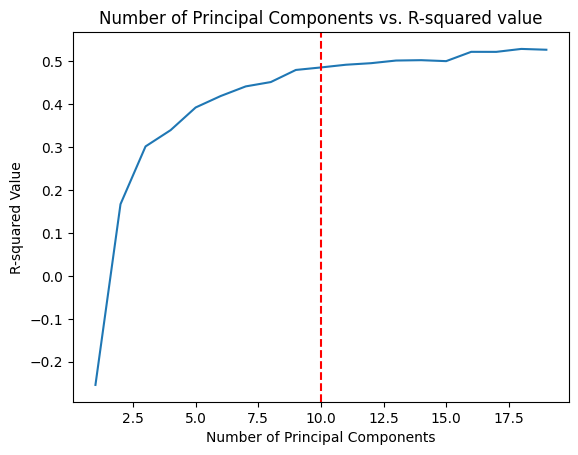

In [112]:
plt.plot(pcas, r2_scores)

# Add axis labels and a title to the plot
plt.xlabel('Number of Principal Components')
plt.ylabel('R-squared Value')
plt.title('Number of Principal Components vs. R-squared value')

plt.axvline(10, color='r', linestyle='--')

# Show the plot
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor 
# Use 25 decision trees in our random forest and initialize
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

In [18]:
prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)


0.5413308414526772


Random forest on the whole dataset

In [115]:
from utils.load import load_everthing_old, make_total_df
import pandas as pd
import numpy as np

In [130]:
distance["0"]

0        11712.0200
1         3702.8090
2         8082.1560
3         1979.1610
4        10114.0700
            ...    
16831    14465.2000
16832           NaN
16833           NaN
16834     2186.2060
16835      396.8041
Name: 0, Length: 16836, dtype: float64

In [131]:
distance  = pd.read_csv("data/distance_data/processed_distances.csv")
distance["0"] = distance["0"].fillna(0)


In [132]:
X_dict, Y_dict = load_everthing_old()
distance  = pd.read_csv("data/distance_data/processed_distances.csv")
distance["0"] = distance["0"].fillna(0)
distance = distance['0'].to_list()

for key, value, new_number in zip(X_dict.keys(), X_dict.values(), distance):
    X_dict[key] = value + (new_number,)


X = list(X_dict.values())
Y = [i[0] for i in Y_dict.values()]
Y = np.log10(Y)


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [126]:
for i in y_train:
    if i == 'NaN':
        print("3")

In [134]:
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

In [135]:
prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)


0.7054144467616206


In [ ]:
def with_distance():

    X_dict, Y_dict = load_everthing_old()
    distance  = pd.read_csv("data/distance_data/processed_distances.csv")
    distance["0"] = distance["0"].fillna(0)
    distance = distance['0'].to_list()

    for key, value, new_number in zip(X_dict.keys(), X_dict.values(), distance):
        X_dict[key] = value + (new_number,)


    X = list(X_dict.values())
    Y = [i[0] for i in Y_dict.values()]
    Y = np.log10(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)